In [22]:
import numpy as np
from scipy.linalg import eig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

##------------------------------------
def ev_tau(k,_gd,_tau,_a,_ell_over_W_squared=0.01):
	"""Takes in a set of parameters and returns the spectrum that 
	corresponds to these parameter values.

	Args:
		k (float): wavenumber
		_gammadot (float): external shear rate
		_tau (float): liquid crystal relaxation time
		_tau_a (float): activity time scale

	Returns:
		list[complx numbers]: a (cleaned of any infinities) list of eigenvalues
	"""
	# resolution
	M = 50

	# parameters 
	_llambda = 1.0
	_eta = 1.0
	# _ell_over_W_squared = 0
	_aux_const = 1 + (_gd*_tau)**2
	_tmp_const = k*k*_llambda / _aux_const 


	##------------------------------------
	mode_number = 94 #79
	do_plot_mode = 0

	##------------------------------------

	II = np.identity(M,dtype='d')

	cbar = np.ones(M,dtype='d')
	cbar[0] = 2.0
	cbar[M-1] = 2.0

	# Chebyshev grid points
	ygl = np.zeros(M,dtype='d')
	for m in range(M):
		ygl[m] = np.cos(np.pi*m/(M-1))

	# Build Chebyshev differentiation matrix
	D1 = np.zeros((M,M),dtype='d')
	for l in range(M):
		for j in range(M):
			if l != j:
				D1[l,j] = cbar[l]*((-1)**(l+j))/(cbar[j]*(ygl[l]-ygl[j]))

	for j in range(1,M-1):
		D1[j,j] = -0.5*ygl[j]/(1.0-ygl[j]*ygl[j])

	D1[0,0] = (2.0*(M-1)*(M-1)+1.0)/6.0
	D1[M-1,M-1] = -D1[0,0]

	# The factor 2 takes care of the domain being from -1/2 to 1/2
	D1 = 2*D1

	D2 = np.dot(D1,D1)

	## Auxiliary matrices

	Lmin = D2 - k*k*II 
	Lplus = D2 + k*k*II 


	## LHS

	## Variable layout
	## psi[0:M] Qxx[M:2*M] Qxy[2*M:3*M] 

	Rpsi  = slice(0*M,1*M)
	RQxx  = slice(1*M,2*M)
	RQxy  = slice(2*M,3*M)


	LHS = np.zeros((3*M,3*M),dtype='D')

	# Stokes equation
	LHS[Rpsi, Rpsi] = (k**4*II - 2*(k**2)*D2 + np.dot(D2,D2))/_tau
	LHS[Rpsi,RQxx] = -2j*_a*k*D1/_eta
	LHS[Rpsi, RQxy] = -(_a*(k**2)*II + _a*D2)/_eta

	## Qxx equation
	LHS[RQxx,Rpsi] = (_tmp_const*(_gd*_tau) * II\
							- 2j*k*_llambda*D1 - (_llambda*_gd*_tau/_aux_const)*D2)
	LHS[RQxx,RQxx] = (1 + _ell_over_W_squared*k*k + 1j*k*ygl*_gd*_tau)*II - _ell_over_W_squared*D2
	LHS[RQxx,RQxy] = -_gd*_tau*II

	## Qxy equation
	LHS[RQxy,Rpsi] = (-_tmp_const*(1 + 2*(_gd*_tau)**2)*II)\
							- _llambda / _aux_const * D2
	LHS[RQxy,RQxx] = _gd*_tau*II
	LHS[RQxy,RQxy] = (1 + _ell_over_W_squared*k*k + 1j*k*ygl*_gd*_tau)*II - _ell_over_W_squared*D2

	RHS = np.zeros((3*M,3*M),dtype='D')
	RHS[RQxx,RQxx] = -_tau*II
	RHS[RQxy,RQxy] = -_tau*II

	## Boundary conditions

	LHS[0]     = np.zeros(3*M,dtype='D') # Psi vanishes at the boundaries
	LHS[1]     = np.zeros(3*M,dtype='D') # and dy(Psi) (?) vanishes at the boundaries
	LHS[M-2]   = np.zeros(3*M,dtype='D') # how does this code account for no-slip?
	LHS[M-1]   = np.zeros(3*M,dtype='D')

	LHS[0,0]      = 1.0
	LHS[1,Rpsi]   = D1[0]
	LHS[M-2,Rpsi] = D1[M-1]
	LHS[M-1,M-1]  = 1.0

	LHS[M]     = np.zeros(3*M,dtype='D') # dy(Qxx) vanishes at the boundaries
	LHS[2*M-1] = np.zeros(3*M,dtype='D')

	LHS[M,RQxx]     = D1[0]
	LHS[2*M-1,RQxx] = D1[M-1]

	LHS[2*M]   = np.zeros(3*M,dtype='D') # dy(Qxy) vanishes at the boundaries
	LHS[3*M-1] = np.zeros(3*M,dtype='D')

	LHS[2*M,RQxy]   = D1[0]
	LHS[3*M-1,RQxy] = D1[M-1]


	RHS[0]     = np.zeros(3*M,dtype='D')
	RHS[1]     = np.zeros(3*M,dtype='D')
	RHS[M-2]   = np.zeros(3*M,dtype='D')
	RHS[M-1]   = np.zeros(3*M,dtype='D')
	RHS[M]     = np.zeros(3*M,dtype='D')
	RHS[2*M-1] = np.zeros(3*M,dtype='D')
	RHS[2*M]   = np.zeros(3*M,dtype='D')
	RHS[3*M-1] = np.zeros(3*M,dtype='D')


	_spec = eig(LHS,RHS,left=0,right=1)

	_eig_list = _spec[0]
	_modes_list = _spec[1]

	_clean_eig_list = list(filter(lambda ev: np.isfinite(ev), _eig_list))
	return _clean_eig_list

#print("at k={}, gammadot={}, tau={}, tau_a={}, fastest growth rate:{:.4f} @ freq={:.4f}"\
#.format(k,_gammadot,_tau,_tau_a,np.real(max_val),np.imag(max_val)))
#print("at k={}, tBar={}, aBar={}, fastest growth rate:{:.4f} @ freq={:.4f}"\
#.format(k,_gammadot*_tau,1/(_gammadot*_tau_a),np.real(max_val),np.imag(max_val)))

"""
f=open('spectrum.txt','w')
for i in range(len(_eig_list)):
	if np.isfinite(_eig_list[i]):
	f.write('%20.18f %20.18f\n'%(np.real(_eig_list[i]),np.imag(_eig_list[i]))    )
f.close()

f=open('list.txt','w')
for i in range(len(_eig_list)):
	f.write('%d %20.18f %20.18f\n'%(i,np.real(_eig_list[i]),np.imag(_eig_list[i]))    )    
f.close()
  """


## OUTPUT
"""
_my_mode=_modes_list[:,mode_number]

_psi=_my_mode[0:M]
_Qxx=_my_mode[M:2*M]
_Qxy=_my_mode[2*M:3*M]

if do_plot_mode:

	f=open('psi.field','w')
	for m in range(M):
	f.write('%f %20.18f %20.18f\n'%(ygl[m],np.real(_psi[m]),np.imag(_psi[m])))
	f.close()

	f=open('Qxx.field','w')
	for m in range(M):
	f.write('%f %20.18f %20.18f\n'%(ygl[m],np.real(_Qxx[m]),np.imag(_Qxx[m])))
	f.close()

	f=open('Qxy.field','w')
	for m in range(M):
	f.write('%f %20.18f %20.18f\n'%(ygl[m],np.real(_Qxy[m]),np.imag(_Qxy[m])))
	f.close()
"""

def max_ev_gd_a_grid(_gds,_as,_k,_tau,ell_over_W_sq=0.01):
	gdv, av = np.meshgrid(_gds,_as)

	# N - number of rows (ny), M - number of columns (nx)
	N, M = len(_as), len(_gds)

	evv = np.zeros([N, M])

	for i in range(N):
		for j in range(M):
			gd = gdv[i][j]
			a = av[i][j]
			evv[i][j] = np.max(np.real(ev_tau(_k,gd,_tau,a,_ell_over_W_squared=ell_over_W_sq)))
	return evv

In [23]:
def graph_spectra_gd_a_grid(gd_specs, a_specs, _tau, _k,l_over_W_sq=0.01):
    gdl,gdr,ngd = gd_specs[0],gd_specs[1],gd_specs[2]
    al,ar,na = a_specs[0], a_specs[1], a_specs[2]
    _gds = np.linspace(gdl,gdr,ngd)
    _as = np.linspace(al,ar,na)
    gdv, av = np.meshgrid(_gds, _as)
    
    mat = np.zeros([na,ngd])
    mat = max_ev_gd_a_grid(_gds,_as,_k,_tau,ell_over_W_sq=l_over_W_sq)
    for i in range(na):
        for j in range(ngd):
            c = "red" if mat[i][j] > 0 else "blue"
            plt.plot(gdv[i][j],av[i][j],".",color=c, picker=True)
    plt.xlabel("$\dot\gamma$")
    plt.ylabel("$a$")
    blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                          markersize=10, label='stable')
    red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='unstable')
    plt.legend(handles=[blue_dot, red_dot])
    plt.title("Stability Plot in the $\dot\gamma$-$a$ plane, $k$={}".format(_k))
    plt.show()

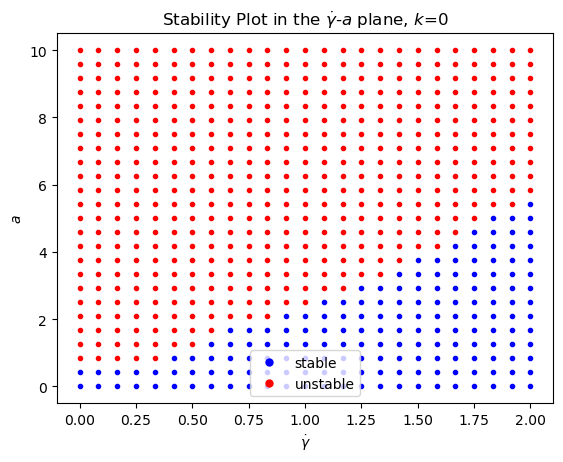

In [2]:
"""THIS CODE BLOCK IS USED FOR TESTING"""
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2,25
al, ar, na = 0,10,25
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k)

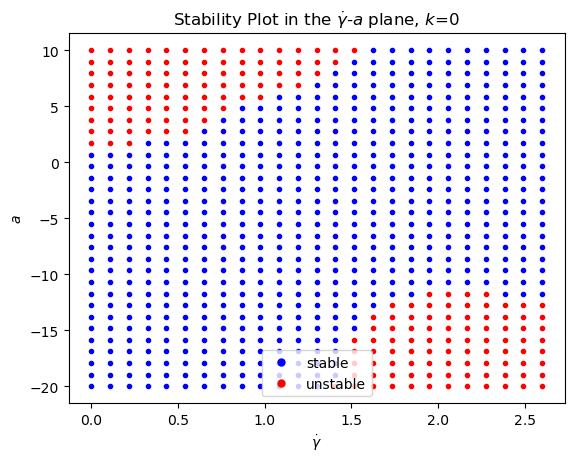

In [26]:
"""NEGATIVE ACTIVITY VALUES"""
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2.6,25
al, ar, na = -20,10,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k)

### ^Compared to the 1D flow case, the critical activity for 2D contractile flow is more negative.

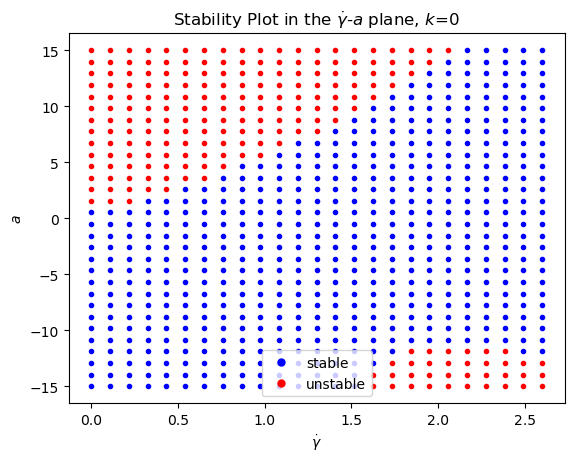

In [27]:
"""ZERO k & ZERO l"""
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2.6,25
al, ar, na = -15,15,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0.01)

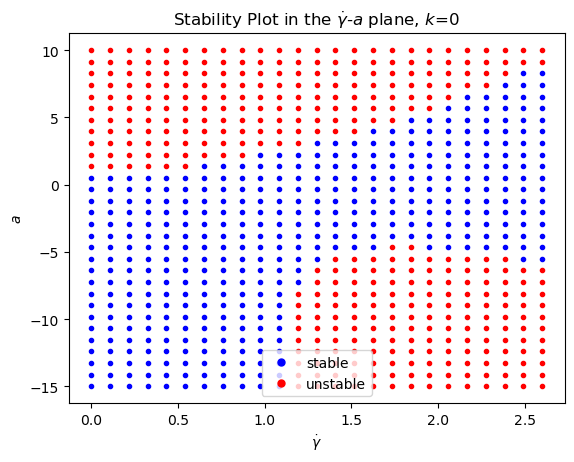

In [24]:
"VERIFYING ZERO k AND l ANALYTIC SOLUTION"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,2.6,25
al, ar, na = -15,10,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0)

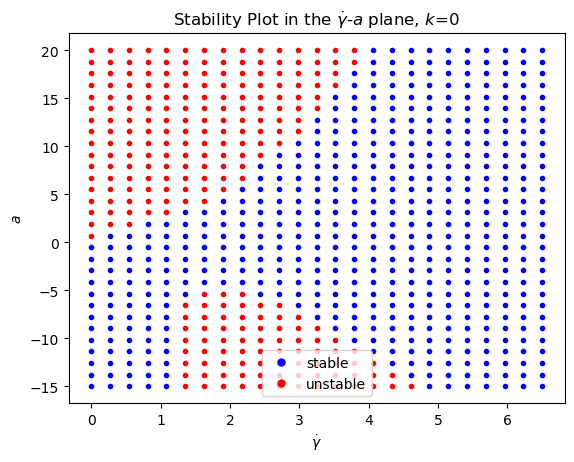

In [18]:
"VERIFYING ZERO k AND l ANALYTIC SOLUTION"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,6.5,25
al, ar, na = -15,20,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0)

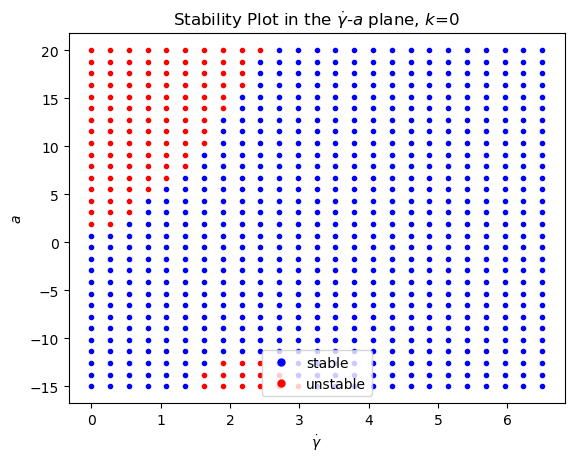

In [19]:
"More shear values at non-zero l"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0,6.5,25
al, ar, na = -15,20,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0.01)

# Observe asymptotic behavior for contractile flows

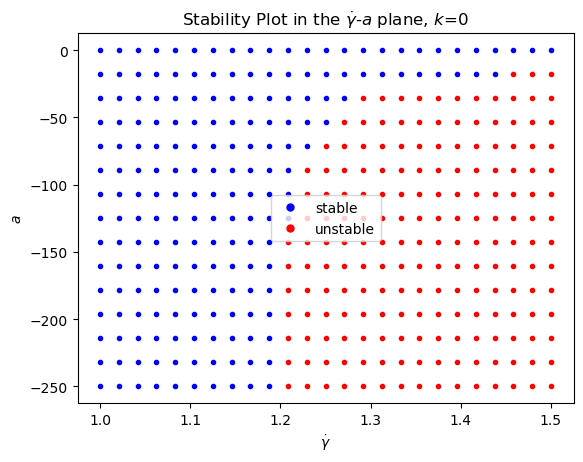

In [25]:
"ASYMPTOTIC NEGATIVE ACTIVITY BEHAVIOR?"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 1.0,1.5,25
al, ar, na = -250,0,15
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0.01)

# The case for $k=l=0$ agrees with analytic solution with critical shear at $\dot\gamma = 1$

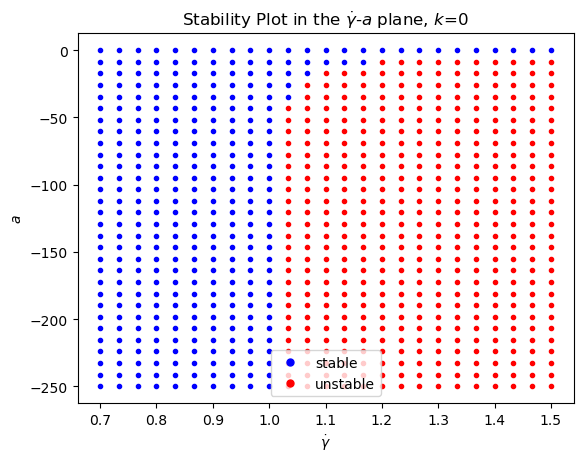

In [21]:
"ASYMPTOTIC NEGATIVE ACTIVITY BEHAVIOR for l=0"
# parameters
tau, k = 1, 0
gdl, gdr, ngd = 0.7,1.5,25
al, ar, na = -250,0,30
   
# make stability plot
graph_spectra_gd_a_grid([gdl,gdr,ngd],[al,ar,na],tau,k,l_over_W_sq=0)